### The following notebook is a tutorial on machine learning to detect change using geospatial_learn
-------------------------------------------------------------------------------------------------------

Documentation on the lib can be found here:

http://geospatial-learn.readthedocs.io/en/latest/

Please use QGIS to visualise results as this is quicker than plotting them in the notebook.

Two Sentinel 2 subsets have been provided along with a pre-made model for detecting change. It is possible you could create your own model - the code is supplied to do so, but this would involve a bit of processing time!

The change detection method used here classifies the change direcly rather than differencing two maps. The training data was collected over 1.5 yrs worth of S2 data over some areas in Kenya

In [1]:
%matplotlib inline

**Before we begin!**

In jupyter, to see the docstring, which explains any function (provided someone has written it!) enter the function as you normaly would, but put a question mark at the end and press shift and enter:
```python
geodata.stack_ras?
```
A scrollable text will appear with an explanation

In [2]:
import matplotlib.pyplot as plt
from geospatial_learn import data, geodata, learning, shape

xgb not available


/bigdrive/anaconda3/lib/python3.5/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [3]:
cd S2_change

/media/ciaran/HD-PZFU3/PyScripts/CLCR_tutorials/S2_change/S2_change


change directory to where you have saved the files

### Paths to the 2 images and model - please alter as appropriate in your own dir

In [4]:
im1 = ('S2_mau_clip_dec2015.tif')

im2 = ('S2_mau_clip_dec2016.tif')

rfModel = 'Ch_MYE_cv5_rf.gz'

### First thing to do is stack our 'before' and 'after' images

In [5]:
stkRas = 'S2_ch_stk.tif'
       
geodata.stack_ras([im1,im2], stkRas)


Processing file     1 of     2,  0.000% completed in 0 minutes.
Filename: S2_mau_clip_dec2015.tif
File Size: 1327x1093x4
Pixel Size: 9.993147 x -9.998413
UL:(757895.629157,9965422.738360)   LR:(771156.535477,9954494.473390)

Processing file     2 of     2, 50.000% completed in 0 minutes.
Filename: S2_mau_clip_dec2016.tif
File Size: 1327x1093x4
Pixel Size: 9.993147 x -9.998413
UL:(757895.629157,9965422.738360)   LR:(771156.535477,9954494.473390)


### Next classify the temporal S2 stack

In [6]:
outMap = 'S2_ch_map'

### A note on model creation with k-fold cross validated grid search


**If you wish to create your own model with training samples train the model with the above data.** 

**Please note this will take time with a large training set**

We first define the parameters we wish to grid search over. The parameters below are just an example, It is of course possible for these to be more numerous at the cost of processing time. The time is a function of the number of possibilities per parameter. There are defaults in geospatial-learn, but it is recommended you define your own.

```python

    params = {'n_estimators': [500], 'max_features': ['sqrt', 'log2'], 
              'min_samples_split':[5,10,20,50], 'min_samples_leaf': [5,10,20,50]}
```          
When we execute the create_model function we get a summary of the no of model fits

'Fitting 5 folds for each of 18 candidates, totalling 90 fits'

I have fixed the n_estimators (trees) at 500 below but this could be varied also.

For a full list of params see:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

We also need a model path to save to:

```python
outModel = 'path/to/mymodel.gz'
```

Then finally run the model calibration:

```python
learning.create_model(trainPix, outPixmodel, clf='rf', cv=3, params=params)
```

In [7]:
learning.classify_pixel_bloc(rfModel, stkRas, 8, outMap, blocksize=256)

/bigdrive/anaconda3/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/bigdrive/anaconda3/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


### Lastly, polygonise the thematic raster for visualisation in QGIS

There is a style file available for this in the zip called 'Change_style.qml'.

For those not familiar with python, the line below uses some string concatenation out of lazyness for renaming files. 

In [8]:
geodata.polygonize(outMap+'.tif', outMap)

**As well as a thematic map, we can produce a multiband map of class probabilities with the following function**

```python 
learning.prob_pixel_bloc(rfModel, stkRas, 8, probMap, 8, blocksize=256)
```
The input variables are the same as the classify function except we also input the number of classes (7 in this case)

In [8]:
learning.prob_pixel_bloc(rfModel, stkRas, 8, outMap+'prob',7, blocksize=256)

/bigdrive/anaconda3/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/bigdrive/anaconda3/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 5/5 [00:40<00:00,  8.15s/it]


### Check the results in QGIS!

In [10]:
geodata.temporal_comp?

/bigdrive/anaconda3/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/bigdrive/anaconda3/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


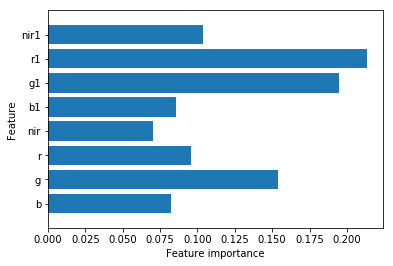

In [10]:
learning.plot_feature_importances(rfModel, ['b','g', 'r', 'nir','b1','g1', 'r1', 'nir1'])

In [9]:
learning.plot_feature_importances?